<a href="https://colab.research.google.com/github/vipashaaV321/Session-Based-Movie-Recommendation-GRU4RECBE/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ACCESS DATASET FROM GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## MovieLens Dataset Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from collections import Counter
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:

movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
ratings = pd.read_csv(ratings_file)

978202/978202 [==============================] - 1s 1us/step
Extracting all the files now...
Done!


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies_file = movielens_dir / "movies.csv"
movies = pd.read_csv(movies_file)

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
result = pd.merge(ratings,movies, on=["movieId"])

In [ ]:
result.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
movielens=result

In [ ]:
# Assuming your DataFrame is named movielens and the title column is 'title'
movielens['title'] = movielens['title'].str.extract(r'([^\(]*)')

# Remove trailing whitespaces
movielens['title_only'] = movielens['title'].str.strip()

movielens.head()

,userId,movieId,rating,timestamp,title,genres,title_only
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story


## MPST Data Preprocessing

In [ ]:
datapath= "drive/My Drive/Data/mpst_full_data.csv"
mpst= pd.read_csv(datapath)

In [ ]:
mpst.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


## Merge based on Titles to obtain movie plots

In [ ]:
result = pd.merge(movielens,mpst, on=["title"])

In [ ]:
result

,userId,movieId,rating,timestamp,title,genres,title_only,imdb_id,plot_synopsis,tags,split,synopsis_source
0,62,176601,5.0,1525795252,Black Mirror,(no genres listed),Black Mirror,tt2085059,"The show looks inwards, at the darker aspects ...","dark, satire",train,imdb
1,306,149334,3.0,1518380372,Nocturnal Animals,Drama|Thriller,Nocturnal Animals,tt4550098,"The movie begins with obese women, dancing nak...","revenge, murder, flashback",train,imdb
2,462,162414,5.0,1478489531,Moonlight,Drama,Moonlight,tt4975722,This film is told through three different poin...,revenge,test,imdb
3,462,162414,5.0,1478489531,Moonlight,Drama,Moonlight,tt0955346,"=== i. Little ===\nIn Liberty City, Miami, Cub...",romantic,test,wikipedia


## Plot Synopsis Preprocessing

# **Lowercasing:**

Description: Convert all characters in the text to lowercase.
Reason: Ensures consistency in word representation, treating "Word" and "word" as the same.

In [ ]:
# Lowercasing
all_plots = all_plots.lower()

# **Removing Punctuation:**

Description: Eliminate any punctuation marks (e.g., periods, commas, exclamation points).
Reason: Punctuation usually doesn't carry much meaning in the context of word clouds.

In [ ]:
# Removing Punctuation
all_plots = all_plots.translate(str.maketrans('', '', string.punctuation))

In [ ]:
import nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Tokenization:**

Description: Break the text into individual words or tokens.
Reason: Word clouds visualize word frequencies, and tokens are the units for analysis.

In [ ]:
# Tokenization
words = word_tokenize(all_plots)

# **Removing Stopwords:**

Description: Exclude common words (stopwords) that don't contribute much meaning.
Reason: Stopwords are frequent but often lack significance in the overall context.

In [ ]:
# Removing Stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]


In [ ]:
# Stemming (using Porter Stemmer)
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in filtered_words]

In [ ]:
# Combine filtered words back into a single string
filtered_plots = ' '.join(filtered_words)

In [ ]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(filtered_plots)

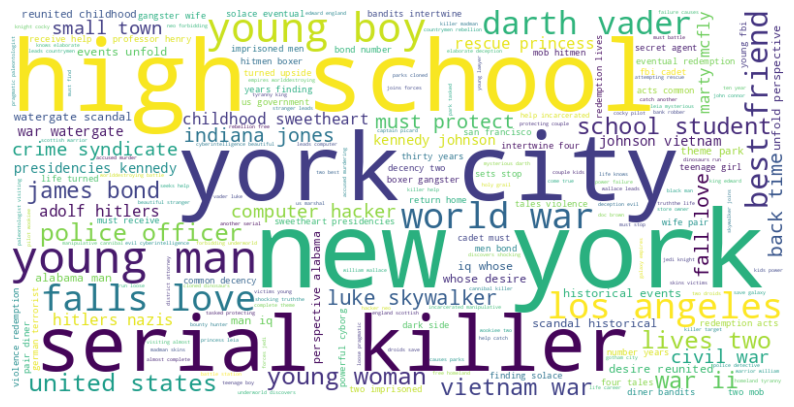

In [ ]:
# Plot the WordCloud image
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
data.head()

,Unnamed: 0,userId,movieId,rating,timestamp,title,genres,plot
0,0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...
1,1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...
2,2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...
3,3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...
4,4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...


# **TOTAL UNIQUE MOVIE**

In [ ]:
# Finding unique values in the 'columnName' column
unique_values = data['movieId'].unique()

# Printing the unique values
print(unique_values)

[   1    3    6 ...  137 1054 3945]


# **TOTAL UNIQUE GENRES**

In [ ]:
# Finding unique values in the 'columnName' column
unique_values = data['genres'].unique()

# Printing the unique values
print(unique_values)

['Adventure|Animation|Children|Comedy|Fantasy' 'Comedy|Romance'
 'Action|Crime|Thriller' 'Mystery|Thriller' 'Crime|Mystery|Thriller'
 'Action|Comedy|Horror|Thriller' 'Adventure|Comedy|Crime|Romance'
 'Action|Drama|War' 'Action|Drama|Romance|War' 'Comedy|War'
 'Action|Romance|Western' 'Comedy' 'Adventure|Comedy' 'Comedy|Drama'
 'Action|Adventure|Sci-Fi' 'Comedy|Crime|Drama|Thriller'
 'Action|Crime|Drama|Thriller' 'Comedy|Drama|Romance|War'
 'Adventure|Children|Romance' 'Action|Comedy|Crime|Fantasy'
 'Action|Thriller' 'Thriller' 'Action|Adventure|Sci-Fi|Thriller'
 'Drama|War' 'Comedy|Romance|Thriller' 'Action|Adventure|Comedy|Romance'
 'Action|Drama|Western' 'Adventure|Drama|Western' 'Crime|Horror|Thriller'
 'Animation|Children|Fantasy|Musical' 'Action|Adventure|Mystery|Thriller'
 'Adventure|Animation|Children|Fantasy|Musical'
 'Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi'
 'Action|Adventure|Thriller' 'Action|Adventure|Romance|Thriller'
 'Adventure|Children|Fantasy|Musical' 'Drama

In [ ]:
# Step 1: Combine all values into a single string
combined_genres = '|'.join(data['genres'])

# Step 2: Split the string to get individual genres
individual_genres = combined_genres.split('|')

# Step 3: Find unique values
unique_genres = set(individual_genres)

# Printing the unique genres
print(unique_genres)

{'Crime', 'Comedy', 'Action', 'War', 'Mystery', 'Musical', 'Romance', 'Fantasy', 'IMAX', 'Western', 'Drama', 'Horror', 'Animation', 'Sci-Fi', 'Thriller', 'Adventure', 'Film-Noir', 'Documentary', 'Children'}


In [ ]:
df = pd.DataFrame(data)

# Split the genres column and explode to create separate rows for each genre
df_genres = df.assign(genres=df['genres'].str.split('|')).explode('genres')


In [ ]:
df_genres

,Unnamed: 0,userId,movieId,rating,timestamp,title,genres,plot
0,0,1,1,4.0,964982703,Toy Story (1995),Adventure,A cowboy doll is profoundly threatened and jea...
0,0,1,1,4.0,964982703,Toy Story (1995),Animation,A cowboy doll is profoundly threatened and jea...
0,0,1,1,4.0,964982703,Toy Story (1995),Children,A cowboy doll is profoundly threatened and jea...
0,0,1,1,4.0,964982703,Toy Story (1995),Comedy,A cowboy doll is profoundly threatened and jea...
0,0,1,1,4.0,964982703,Toy Story (1995),Fantasy,A cowboy doll is profoundly threatened and jea...
...,...,...,...,...,...,...,...,...
58498,58498,609,137,3.0,847221054,Man of the Year (1995),Documentary,Mockumentary look at Playgirl Magazine centerf...
58499,58499,610,1054,2.0,1493850563,Get on the Bus (1996),Drama,A disparate group of African-American men trav...
58500,58500,610,3945,3.0,1493850190,Digimon: The Movie (2000),Adventure,"Throughout three different stories, Kari Kamiy..."
58500,58500,610,3945,3.0,1493850190,Digimon: The Movie (2000),Animation,"Throughout three different stories, Kari Kamiy..."


In [ ]:
# Merge the original DataFrame with the exploded genres DataFrame
df_merged = pd.merge(df, df_genres, left_index=True, right_index=True, how='outer')

In [ ]:
df_merged

,Unnamed: 0_x,userId_x,movieId_x,rating_x,timestamp_x,title_x,genres_x,plot_x,Unnamed: 0_y,userId_y,movieId_y,rating_y,timestamp_y,title_y,genres_y,plot_y
0,0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...,0,1,1,4.0,964982703,Toy Story (1995),Adventure,A cowboy doll is profoundly threatened and jea...
0,0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...,0,1,1,4.0,964982703,Toy Story (1995),Animation,A cowboy doll is profoundly threatened and jea...
0,0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...,0,1,1,4.0,964982703,Toy Story (1995),Children,A cowboy doll is profoundly threatened and jea...
0,0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...,0,1,1,4.0,964982703,Toy Story (1995),Comedy,A cowboy doll is profoundly threatened and jea...
0,0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...,0,1,1,4.0,964982703,Toy Story (1995),Fantasy,A cowboy doll is profoundly threatened and jea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58498,58498,609,137,3.0,847221054,Man of the Year (1995),Documentary,Mockumentary look at Playgirl Magazine centerf...,58498,609,137,3.0,847221054,Man of the Year (1995),Documentary,Mockumentary look at Playgirl Magazine centerf...
58499,58499,610,1054,2.0,1493850563,Get on the Bus (1996),Drama,A disparate group of African-American men trav...,58499,610,1054,2.0,1493850563,Get on the Bus (1996),Drama,A disparate group of African-American men trav...
58500,58500,610,3945,3.0,1493850190,Digimon: The Movie (2000),Adventure|Animation|Children,"Throughout three different stories, Kari Kamiy...",58500,610,3945,3.0,1493850190,Digimon: The Movie (2000),Adventure,"Throughout three different stories, Kari Kamiy..."
58500,58500,610,3945,3.0,1493850190,Digimon: The Movie (2000),Adventure|Animation|Children,"Throughout three different stories, Kari Kamiy...",58500,610,3945,3.0,1493850190,Digimon: The Movie (2000),Animation,"Throughout three different stories, Kari Kamiy..."


In [ ]:

# Group by user and genre, and calculate the mean rating
genre_ratings = df_merged.groupby(['userId_y', 'genres_y'])['rating_y'].mean().reset_index()


In [ ]:
# Print the result
print(genre_ratings)

      userId_y   genres_y  rating_y
0            1     Action  4.322222
1            1  Adventure  4.392857
2            1  Animation  4.714286
3            1   Children  4.560976
4            1     Comedy  4.268293
...        ...        ...       ...
9143       610    Romance  3.788462
9144       610     Sci-Fi  4.282609
9145       610   Thriller  4.150685
9146       610        War  4.181818
9147       610    Western  4.045455

[9148 rows x 3 columns]


In [ ]:

# Merge the original DataFrame with the exploded genres DataFrame
df_merged = pd.merge(df, df_genres, left_index=True, right_index=True, how='outer')

# Group by user and genre, and calculate the mean rating
genre_ratings = df_merged.groupby(['userId', 'genres'])['rating'].mean().reset_index()

# Print the result
print(genre_ratings)

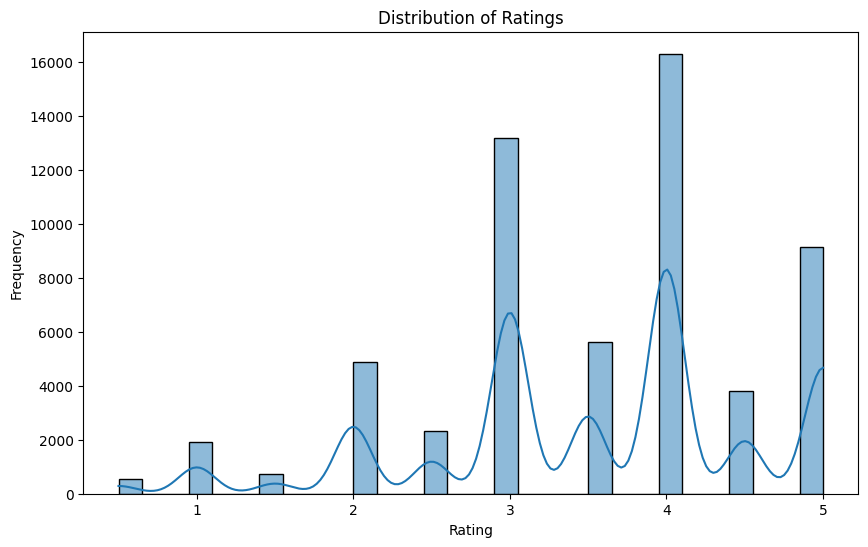

In [ ]:
# Visualize the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(data['rating'], bins=30, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

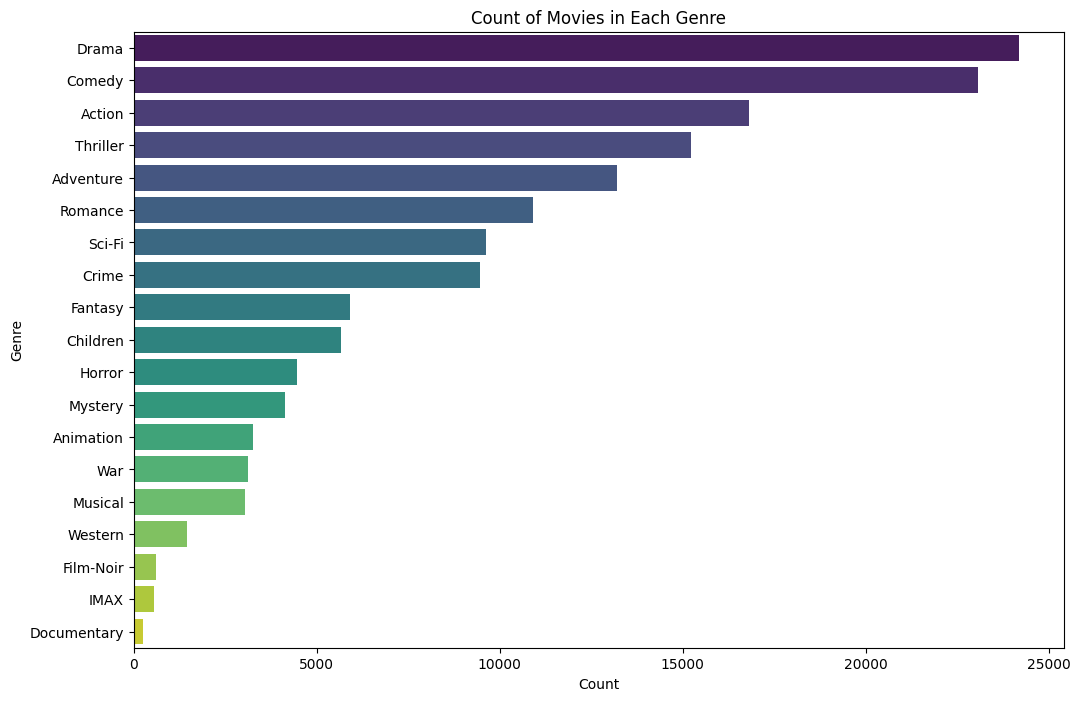

In [ ]:
# Visualize the count of movies in each genre
genres = data['genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=genres.values, y=genres.index, palette='viridis')
plt.title('Count of Movies in Each Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


In [ ]:
# Visualize the average rating for each genre
genre_avg_rating = data.groupby('genres')['rating'].mean().sort_values(ascending=False).reset_index()

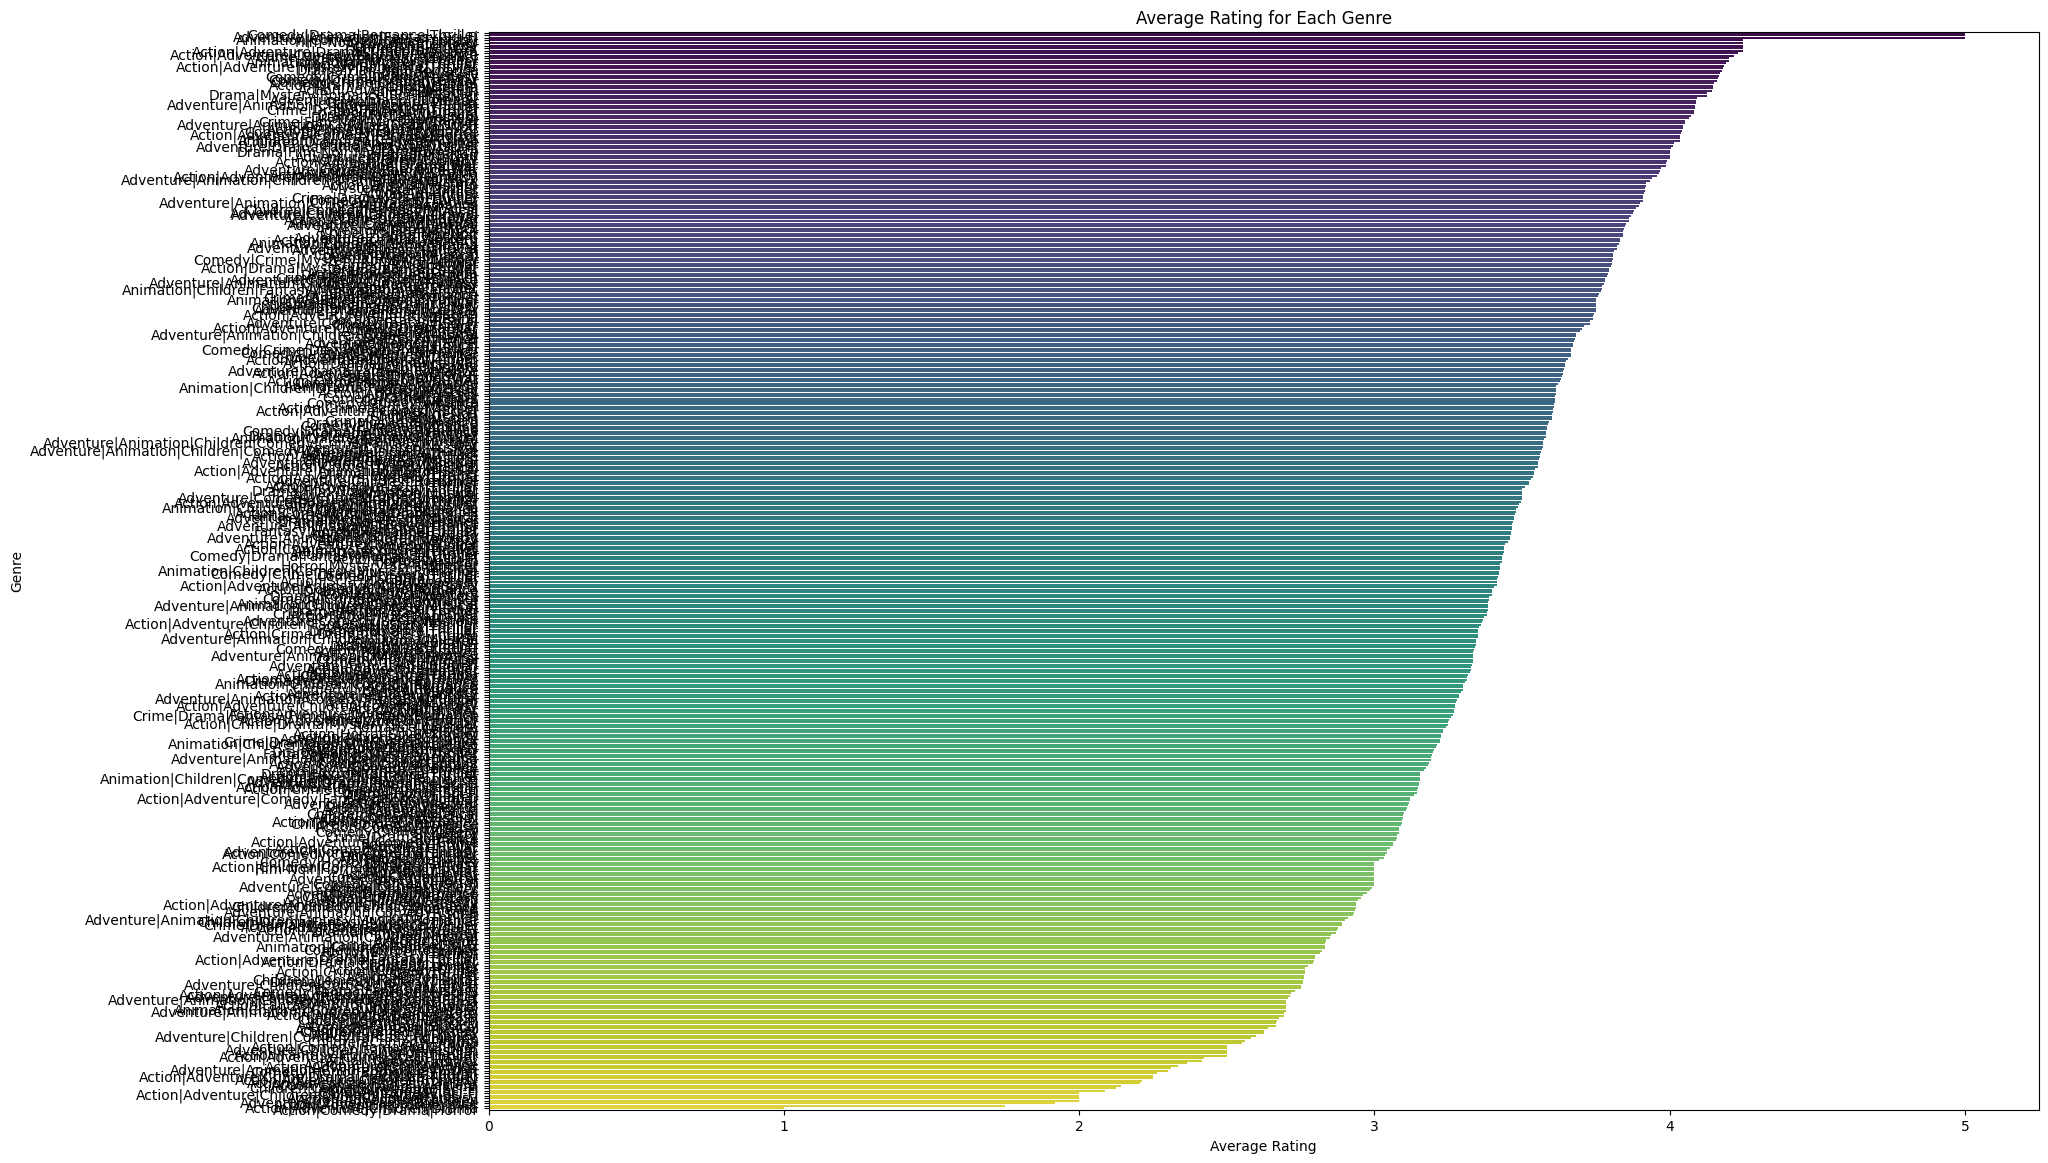

In [ ]:
plt.figure(figsize=(20, 14))
sns.barplot(x='rating', y='genres', data=genre_avg_rating, palette='viridis')
plt.title('Average Rating for Each Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()


In [ ]:
plot_synopsis_corpus = mpst['plot_synopsis'].tolist()

In [ ]:
# Text Preprocessing of plot_synopsis_corpus
processed_corpus = []
for doc in plot_synopsis_corpus:
    tokens = word_tokenize(doc.lower())  # Tokenization and Lowercasing
    tokens = [word for word in tokens if word.isalnum()]  # Remove Punctuation
    processed_corpus.append(tokens)

In [ ]:
movie_synopses = mpst['plot_synopsis'].tolist()
processed_movie_synopses = [word_tokenize(s.lower()) for s in movie_synopses]

# Train Word2Vec model on movie synopses and user input
word2vec_model = Word2Vec(processed_movie_synopses, vector_size=100, window=5, min_count=1, sg=0)

# Get Word2Vec embeddings for user input
user_embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]

# Example: Printing user embeddings
print("User Embeddings:")
print(user_embeddings)

## Visualization

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import string
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/IR_Project/mpst_full_data.csv')

In [ ]:
df

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb
...,...,...,...,...,...,...
14823,tt0219952,Lucky Numbers,"In 1988 Russ Richards (John Travolta), the wea...","comedy, murder",test,wikipedia
14824,tt1371159,Iron Man 2,"In Russia, the media covers Tony Stark's discl...","good versus evil, violence",train,wikipedia
14825,tt0063443,Play Dirty,During the North African Campaign in World War...,anti war,train,wikipedia
14826,tt0039464,High Wall,Steven Kenet catches his unfaithful wife in th...,murder,test,wikipedia


In [ ]:
plot_synopsis_corpus = df['plot_synopsis'].tolist()

In [ ]:
plot_synopsis_corpus[0]

'Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the \'Three Faces of Fear\'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl who returns to her spacious, basement apartment after an evening out when she immediately gets beset by a series of strange phone calls. The caller soon identified himself as Frank, her ex-pimp who has recently escaped from prison. Rosy is terrified for it was her testimony that landed the man in jail. Looking for solace, Rosy phones her lesbian lover Mary (Lynda Alfonsi). The two women have been estranged for some time, but Rosy is certain that she is the only one who can help her. Mary agrees to come over that night. Seconds later, Frank calls again, promising that no matter who she calls for protection, he will have his revenge. Unknown to Rosy, Mary is the caller impersonating Frank. Marry

In [ ]:
len(plot_synopsis_corpus)

14828

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Text Preprocessing of plot_synopsis_corpus
processed_corpus = []
lemmatizer = WordNetLemmatizer()
for doc in plot_synopsis_corpus:
    tokens = word_tokenize(doc.lower())  # Tokenization and Lowercasing
    tokens = [word for word in tokens if word.isalnum()]  # Remove Punctuation
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed_corpus.append(tokens)

In [ ]:
len(processed_corpus)

14828

In [ ]:
processed_corpus

In [ ]:
type(processed_corpus)

list

In [ ]:
import pandas as pd

# Choose the column you want to create a corpus from
column_name = 'plot_synopsis'

# Concatenate all sentences from the chosen column to create a corpus
corpus = ' '.join(df[column_name].astype(str))

# Print the first 500 characters of the corpus (adjust as needed)
print(corpus[:500])


Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl who returns to her spacious, basement apartment after an evening out when she immediately gets beset by a series of strange phone calls. The caller soon identified himself as Frank, her ex-pimp who has rec


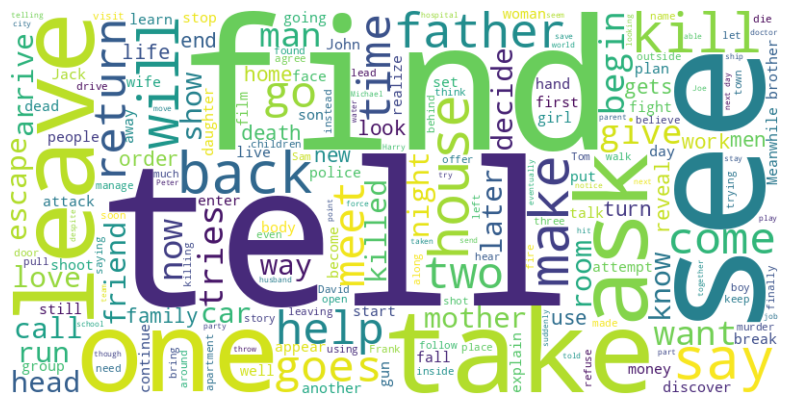

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
# Word Embedding - Word2Vec
embedding_dim = 100  # Define the dimension of word embeddings
word2vec_model = Word2Vec(processed_corpus, vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [ ]:
#Access Word Embeddings
word_embeddings = word2vec_model.wv

# Example: Get Embedding of a Word
word = "camera"
embedding = word_embeddings[word]
print(f"Embedding for '{word}': {embedding}")

Embedding for 'camera': [ 0.17782505  1.9454697   0.69179904 -2.0237012  -0.93387294 -1.2945733
 -0.7780032  -2.3190122  -1.6006284   3.367216    1.6725556   2.5383098
 -0.55388933 -1.3606747   1.3533133  -0.8800583   2.627544    1.4000807
  4.2975473   2.781746   -2.4039614  -0.15695815  1.4267663   1.939173
 -0.5837629  -1.7129793  -1.3287972   3.4934957  -0.77865094  0.144574
  1.5710287  -0.8082927   2.0581584  -0.3491314  -2.6107893  -2.0104356
 -0.6499841   0.4887517   0.00875055 -0.3573927  -0.7920647   1.4242544
 -1.0167869  -0.5923361  -3.9697385   0.45429987 -1.0179272   0.7766314
 -2.5662265  -0.6881038  -0.6197127  -0.5540221  -1.1277502   1.68888
  0.55636925  0.9475992  -1.8192544  -1.353354    0.04888808 -1.5356488
 -0.05793001 -0.32704324  2.7942996  -0.14870024 -0.7563378  -0.6413549
  2.2237442  -0.51941407  0.6963407  -0.6630853  -1.2046535   0.23736404
 -1.7450966  -0.70873874 -0.11799512  1.106667   -0.18568295  0.5043452
 -0.99049896 -1.7566978  -2.0116906  -0.252

# Application

In [ ]:
# Sample User-provided text
user_text = "crazy scientific movie about bomb blast."

# Preprocess user text (similar to the preprocessing done on movie synopses)
tokens = word_tokenize(user_text.lower())  # Tokenization and Lowercasing
tokens = [word for word in tokens if word.isalnum()]  # Remove Punctuation
processed_user_input = ' '.join(tokens)  # Join tokens back into a string

In [ ]:
# Create TF-IDF vectors for movie synopses and user text
vectorizer = TfidfVectorizer()
synopsis_vectors = vectorizer.fit_transform(df['plot_synopsis'])
user_vector = vectorizer.transform([processed_user_input])

user_vector

<1x125277 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [ ]:
# Calculate cosine similarity between user text and movie synopses
similarities = cosine_similarity(user_vector, synopsis_vectors).flatten()

# Get top N similar movies based on similarities
top_similar_movies_indices = similarities.argsort()[-10:][::-1]  # Get top 5 similar movies
similar_movies = df.iloc[top_similar_movies_indices]

# Display recommended movies
print("Recommended Movies:")
for index, movie in similar_movies.iterrows():
    print(f"Title: {movie['title']}, Tags: {movie['tags']}")

Recommended Movies:
Title: Day One, Tags: suspenseful
Title: Hey Good Lookin', Tags: comedy, cult, violence, flashback, psychedelic, humor, satire
Title: The Hurt Locker, Tags: mystery, realism, murder, violence, action, suspenseful
Title: Tales from the Hood, Tags: violence, murder, blaxploitation
Title: The Jokers, Tags: satire
Title: Ticker, Tags: comedy, boring, neo noir, flashback, good versus evil, revenge
Title: Cancel My Reservation, Tags: murder
Title: Dark Star, Tags: comedy, cult, absurd, psychedelic, satire, philosophical
Title: Naked Gun 33 1/3: The Final Insult, Tags: comedy, boring, cult, flashback, absurd, humor, revenge, entertaining
Title: The Small Back Room, Tags: suspenseful


# word2vec

In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Sample User-provided text
user_text = "A romantic drama with a touch of mystery."

# Preprocess user text (similar to the preprocessing done on movie synopses)
tokens = word_tokenize(user_text.lower())  # Tokenization and Lowercasing
tokens = [word for word in tokens if word.isalnum()]  # Remove Punctuation

# Convert list of tokens to a list of lists for Word2Vec training
processed_user_input = [tokens]

# Sample movie synopses (replace with your actual movie synopsis data)
movie_synopses = df['plot_synopsis'].tolist()
processed_movie_synopses = [word_tokenize(s.lower()) for s in movie_synopses]

# Train Word2Vec model on movie synopses and user input
word2vec_model = Word2Vec(processed_movie_synopses + processed_user_input, vector_size=100, window=5, min_count=1, sg=0)

# Get Word2Vec embeddings for user input
user_embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]

# Example: Printing user embeddings
print("User Embeddings:")
print(user_embeddings)

User Embeddings:
[array([-0.38221732,  0.29233816,  0.6976028 , -0.8289885 , -1.6431183 ,
       -1.6695638 ,  2.4349396 ,  2.1710043 , -0.26822785,  0.03672486,
        0.40136725,  3.093706  , -2.1853757 , -0.5638251 , -0.08725568,
       -2.661989  , -0.38833615, -0.09869929,  0.9781087 , -0.80499613,
       -0.29336324,  2.221858  ,  2.7816808 , -0.18627647, -0.31780693,
       -0.07885998, -1.425745  , -2.5289483 , -0.31659603, -0.23460838,
        0.53080475, -0.52769494, -2.2561562 , -1.7105088 ,  2.9251935 ,
        0.6089198 , -0.22839838,  2.396592  ,  1.9653558 ,  0.5504541 ,
       -1.0181305 ,  0.47664848, -2.6207027 , -2.3500614 , -1.4374231 ,
       -1.3941828 , -2.3636556 ,  1.66569   , -0.29694697,  0.35946986,
       -1.8076895 ,  0.05562835,  1.6299595 ,  0.70004827,  0.28000703,
       -2.5437145 ,  3.1569014 , -0.563819  ,  0.8466227 ,  0.62631595,
        1.1199726 ,  1.1788138 ,  1.3591554 , -2.1599836 ,  0.95398057,
        0.98333484, -1.8408251 , -1.4955696 , 

In [ ]:
# Specify the word for which you want to find the embedding
target_word = 'romantic'

# Check if the target word is in the vocabulary
if target_word in word2vec_model.wv:
    # Get the embedding of the target word
    embedding = word2vec_model.wv[target_word]
    print(f"Embedding for '{target_word}':")
    print(embedding)
else:
    print(f"'{target_word}' is not in the vocabulary.")


Embedding for 'romantic':
[ 1.01459    -0.42054477  1.007354   -1.1474352   0.01894481 -0.3510881
  0.20217824  1.8840697  -1.9104625  -1.9260058  -0.29553232  0.61629385
 -0.02564389 -1.2842205  -1.1643187   0.2575353  -0.49867156 -0.6256078
  2.7737694  -1.8484802  -1.1336126  -0.5908546   0.19301693  0.30664384
  1.0916916   0.5556604  -0.15858912 -2.292136    0.61113995  0.5266099
  0.6129156   1.6071273  -1.6917033   0.31451425  3.0273957  -1.4352676
  0.53476727  0.44597685  1.1573639  -0.11438341  1.1223749   1.9011974
  0.288171    2.0770378  -0.09924548 -0.6938374   0.5486263  -1.3798357
  2.9589155   1.7702096   0.5171877  -1.0635226   0.9407435   0.02579158
  0.17341815  2.566667    0.23565044 -0.01653631  0.49166667 -1.0453339
  1.3422474   1.7226415   1.2960196  -1.1603075  -0.71222067  0.6534624
  0.29786727  0.3028694  -1.0089215  -1.9890671   0.05291404  0.5608938
  1.1997095  -1.5488408   0.1096265   2.2586489   0.67457014 -0.27109677
  0.43190792  0.43005943 -0.937197

In [ ]:
word2vec_model.wv['mysterious']

array([-0.11513425,  0.8833768 , -1.0779    ,  1.9477739 , -0.31910783,
       -1.2041066 ,  1.1291994 , -0.16169234, -1.0635452 ,  0.6969962 ,
        0.05111349, -0.13789344, -0.72029096, -0.48248288, -1.2178439 ,
       -2.4864123 ,  0.23184922, -1.1990163 , -0.49185523, -1.0855881 ,
        0.3110976 , -1.3765268 ,  1.2904196 ,  0.8455562 ,  0.9562826 ,
       -0.54254246, -0.24431275, -0.52633363,  1.6772923 ,  0.15150835,
       -0.3005031 , -1.1633291 , -0.04052749, -1.0694207 ,  0.42496854,
       -2.0591176 , -0.2083842 ,  1.0218208 ,  1.1205305 , -1.2813853 ,
       -0.42285424, -0.62401384, -2.8077102 , -2.5385282 , -0.09752723,
        2.5196693 , -1.6788589 , -0.2936464 ,  0.78270215,  1.4933043 ,
       -1.8496795 , -0.09902196,  0.87583137,  0.87270975, -1.2474061 ,
        1.8158984 ,  2.1025617 , -0.32103986,  1.3191426 ,  2.1089127 ,
       -2.5453696 ,  0.00425804,  0.03167377, -0.686798  ,  0.5755047 ,
        1.5967338 , -0.33037663, -0.29089022, -2.1824188 ,  0.08

In [ ]:
word2vec_model.wv['action']

array([ 0.4505983 , -1.2340409 ,  1.3911607 , -1.4406687 , -0.6936751 ,
       -0.70758516,  0.8316602 , -0.9259261 , -1.1807446 , -0.26319817,
       -0.24991818, -0.7659886 , -0.54658055,  1.8877864 , -0.9743373 ,
        1.0645609 , -0.28605798, -1.6976024 ,  0.6630439 ,  1.4646533 ,
        1.0537765 , -0.8092848 , -0.6699454 , -0.506763  , -0.02888033,
        0.9862312 ,  1.3576597 , -1.5356028 , -1.2918432 , -1.3753921 ,
        0.71713364,  0.24708101, -0.5976502 , -3.0588572 , -0.10783393,
       -0.19861826,  0.2076263 , -0.6283019 , -0.72444195, -1.9830025 ,
        0.28751758,  0.5868133 , -0.23119412,  1.0774729 ,  1.1305162 ,
       -2.023732  , -1.2645123 , -0.36472505, -0.1827337 , -0.7292877 ,
        1.1492088 , -0.18954624,  1.0624344 ,  1.5925134 ,  0.23551705,
       -0.5346753 , -0.72792524,  1.7398397 , -0.9885454 ,  0.29425114,
        2.1394224 , -0.2787812 , -0.14745286,  0.6860426 , -1.2663708 ,
        0.80046976, -3.1597974 ,  0.94819474, -0.6648955 , -4.17

In [ ]:
word2vec_model.wv['thriller']

(100,)

In [ ]:
word2vec_model.wv['comedy']

array([ 4.00029540e-01, -3.53075773e-01,  1.02234221e+00,  2.08493188e-01,
       -6.14058673e-01, -1.21995576e-01, -3.58504467e-02,  9.47104096e-01,
       -7.60643721e-01, -2.44437262e-01, -5.49624205e-01,  1.27965463e-02,
        1.23657800e-01, -7.15926409e-01, -5.25094450e-01,  3.48165691e-01,
        7.61271119e-01, -3.89602244e-01,  1.40717924e-01, -4.74675357e-01,
       -5.96248031e-01, -4.38450038e-01, -3.10263872e-01, -7.23210573e-01,
        5.72946727e-01,  2.08171278e-01,  2.05112457e-01, -1.28768134e+00,
       -1.38604748e+00, -8.86750638e-01,  2.25792781e-01, -2.83428788e-01,
        4.82494295e-01,  2.39861682e-02, -3.67800623e-01, -1.06860018e+00,
       -1.84059307e-01, -6.05185283e-04,  2.16691807e-01, -1.31713772e+00,
        8.88846993e-01,  4.08550829e-01, -7.79143393e-01,  1.42397368e+00,
        3.25546533e-01, -6.19374096e-01,  4.27003026e-01, -7.85638511e-01,
        1.07850969e+00,  5.81799090e-01, -1.71002433e-01,  2.47269347e-01,
        6.61243796e-01,  

In [ ]:
word2vec_model.wv['movie']

(100,)

In [ ]:
word2vec_model.wv['king']

In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Assuming you have a dictionary of word embeddings where the keys are words
# and the values are the corresponding embeddings
word_embeddings = {
    'horror': np.array(word2vec_model.wv['horror']),  # Replace with your actual embeddings
    'romantic': np.array(word2vec_model.wv['romantic']),
    'mysterious': np.array(word2vec_model.wv['mysterious']),
    'action': np.array(word2vec_model.wv['action']),
    'violence': np.array(word2vec_model.wv['violence']),  # Replace with your actual embeddings
    'cult': np.array(word2vec_model.wv['cult']),
    'comedy': np.array(word2vec_model.wv['comedy']),
    'movie': np.array(word2vec_model.wv['movie']),
}

words = list(word_embeddings.keys())
embeddings = np.array([word_embeddings[word] for word in words])

# Calculate pairwise cosine similarity
similarity_matrix = cosine_similarity(embeddings)

# Dimensionality reduction using PCA
pca = PCA(n_components=3)
embeddings_pca = pca.fit_transform(embeddings)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=3, perplexity=3)
embeddings_tsne = tsne.fit_transform(embeddings)

# Visualize the most relevant connections dynamically
num_top_connections = 2  # Set the number of top connections to visualize

fig = go.Figure()

# Add traces for PCA plot
fig.add_trace(go.Scatter3d(
    x=embeddings_pca[:, 0],
    y=embeddings_pca[:, 1],
    z=embeddings_pca[:, 2],
    mode='markers',
    marker=dict(color='blue', size=8),
    text=words,
    name='PCA'
))

# Add traces for t-SNE plot
fig.add_trace(go.Scatter3d(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    z=embeddings_tsne[:, 2],
    mode='markers',
    marker=dict(color='red', size=8),
    text=words,
    name='t-SNE'
))

# Visualize the top connections
for i in range(len(words)):
    for j in np.argsort(similarity_matrix[i])[-num_top_connections:][::-1]:
        if i != j:
            fig.add_trace(go.Scatter3d(
                x=[embeddings_pca[i, 0], embeddings_pca[j, 0]],
                y=[embeddings_pca[i, 1], embeddings_pca[j, 1]],
                z=[embeddings_pca[i, 2], embeddings_pca[j, 2]],
                mode='lines',
                line=dict(color='black', width=3),
                name=f'{words[i]} to {words[j]} (PCA)'
            ))

            fig.add_trace(go.Scatter3d(
                x=[embeddings_tsne[i, 0], embeddings_tsne[j, 0]],
                y=[embeddings_tsne[i, 1], embeddings_tsne[j, 1]],
                z=[embeddings_tsne[i, 2], embeddings_tsne[j, 2]],
                mode='lines',
                line=dict(color='gray', width=3, dash='dash'),
                name=f'{words[i]} to {words[j]} (t-SNE)'
            ))

fig.update_layout(scene=dict(aspectmode='data'))
fig.update_layout(title_text=f'3D Word Embeddings Visualization with Top {num_top_connections} Connections')

fig.show()


In [ ]:
pip install wordcloud


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(user_embeddings)


In [ ]:
words = ['ghost','vampire']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, cmap="YlGnBu", xticklabels=words, yticklabels=words)
plt.title('Word Similarity Matrix')
plt.show()


## BERT Embedding

In [ ]:
!pip install transformers

In [ ]:
!pip install bert-for-tf2

In [ ]:
from transformers import BertTokenizer
from bert import BertModelLayer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a given text
def get_bert_embeddings(text):
    # Tokenize input text
    tokens = tokenizer.encode_plus(text, return_tensors='tf', max_length=512, truncation=True)

    # Load pre-trained BERT model
    bert_model = BertModelLayer.from_params('bert-base-uncased')
    model = Model(inputs=bert_model.inputs, outputs=bert_model.output)

    # Get BERT model embeddings
    embeddings = model.predict(tokens['input_ids'])[0].mean(axis=0)

    print(embeddings)

    return embeddings

In [ ]:
movie_synopses = mpst['plot_synopsis'].tolist()
processed_movie_synopses = [word_tokenize(s.lower()) for s in movie_synopses]

In [ ]:
get_bert_embeddings(processed_movie_synopses)